In [63]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import Point
from haversine import haversine

In [2]:
pwd

'c:\\Users\\chldy\\OneDrive\\바탕 화면\\용용\\딥러닝 부트캠프\\교육데이터공모전'

### 1. 부평동

In [52]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][121]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    exdf= gpd.read_file(exclusion_shp_paths[0])
    ex_poly_list= []
    ex_poly_list.append(exdf['geometry'][16])
    ex_poly_list.append(exdf['geometry'][19])
    ex_poly_list.append(exdf['geometry'][20])
    ex_poly_list.append(exdf['geometry'][23])

    
    print(len(ex_poly_list))
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poly_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/'
shp_file_path = path+'INCHEON_BJUMD_POPP_STAT.shx'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'LSMD_CONT_UD801.shp', path+'LSMD_CONT_UI702.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 100  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



4
시도 횟수: 0, 유효한 사이트 수: 0
[[175798.31445675 541304.12036777]
 [174886.04715089 542132.70574243]
 [176041.26467595 544028.53913088]
 [174744.87169859 543312.22576146]
 [175824.49510555 543477.71790561]
 [176214.87714845 544118.16978362]
 [175049.32810088 541849.55176499]
 [176319.21059343 543723.46978863]
 [176218.15427721 544250.24342627]
 [175539.95699944 545267.72284796]
 [175145.17155852 543507.39627556]
 [176273.92311287 543785.31571149]
 [176354.79160256 543613.21238103]
 [174768.05481639 542409.36308789]
 [175788.94549136 542724.76156842]
 [175124.25883729 542075.41667841]
 [175819.86601159 543746.06556583]
 [174606.58994246 542785.89488184]
 [175591.83355449 544061.62721313]
 [176307.58825222 544443.66973741]
 [174987.2477601  542318.86630809]
 [175838.40008692 542853.52141437]
 [174860.63879892 542230.60076987]
 [175602.89497317 542297.96660954]
 [175661.02076205 544952.95703126]
 [175197.40980756 542116.4434822 ]
 [176180.47940749 542964.42337796]
 [175904.17116848 543444.39409

In [54]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [55]:
sites_df

,경도,위도
0,175798.314457,541304.120368
1,174886.047151,542132.705742
2,176041.264676,544028.539131
3,174744.871699,543312.225761
4,175824.495106,543477.717906
...,...,...
95,174468.897846,543016.278077
96,175715.153494,543337.592397
97,175161.847480,543610.018014
98,175545.524536,544207.176266


In [57]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_24768\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

               경도             위도   latitude   longitude
0   175798.314457  541304.120368  37.470851  126.726411
1   174886.047151  542132.705742  37.478292  126.716070
2   176041.264676  544028.539131  37.495404  126.729068
3   174744.871699  543312.225761  37.488916  126.714433
4   175824.495106  543477.717906  37.490436  126.726635
..            ...            ...        ...         ...
95  174468.897846  543016.278077  37.486242  126.711323
96  175715.153494  543337.592397  37.489170  126.725404
97  175161.847480  543610.018014  37.491610  126.719138
98  175545.524536  544207.176266  37.497001  126.723457
99  176054.980984  544003.159070  37.495176  126.729224

[100 rows x 4 columns]


C:\Users\chldy\AppData\Local\Temp\ipykernel_24768\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(proj_UTM, proj_WGS84, x, y)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in

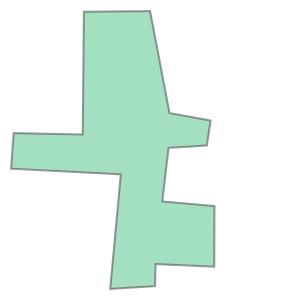

In [22]:
ex= path+'상습침수구역.shx'
gpff= gpd.read_file(ex)
gpff['geometry'][20]

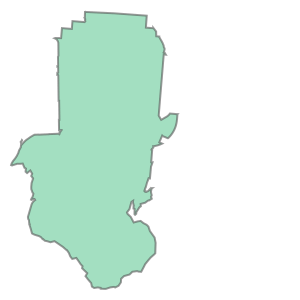

In [ ]:
gdf['geometry'][121]

In [43]:
apt= pd.read_csv('인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)


In [44]:
apt= apt[apt['legal_dong']=='부평동']

In [ ]:
apt[apt['lo']>90]

In [88]:
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points


array([[ 37.49641145, 126.72984233],
       [ 37.49091882, 126.71850116],
       [ 37.49081395, 126.71892222],
       [ 37.4914431 , 126.72748851],
       [ 37.49087875, 126.72752891],
       [ 37.49079964, 126.72840547],
       [ 37.50095247, 126.72159699],
       [ 37.5011451 , 126.72237192],
       [ 37.50179182, 126.72218726],
       [ 37.50253875, 126.7220125 ],
       [ 37.50286994, 126.72206628],
       [ 37.50321458, 126.72200652],
       [ 37.50430416, 126.72192006],
       [ 37.50492669, 126.72100499],
       [ 37.49053562, 126.73067746],
       [ 37.49071793, 126.73147446],
       [ 37.49023988, 126.73146194],
       [ 37.49014941, 126.73176231],
       [ 37.49007419, 126.73198693],
       [ 37.49023942, 126.73272792],
       [ 37.48979858, 126.73278954],
       [ 37.49015718, 126.73297206],
       [ 37.49011293, 126.73339555],
       [ 37.48381954, 126.71617309],
       [ 37.48453593, 126.71740435],
       [ 37.48642931, 126.7198176 ],
       [ 37.48718189, 126.72296349],
 

In [89]:
# haversine -> meter 단위로 수정
def mclp(주택_points, K, radius):

    print('  Number of points %g' % 주택_points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    
    D = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
 
    
    D4 = []
    for i in 주택_points:
        site = []
        
        for j in sites:
            print(i, j)
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)

    for i in [D4]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가

    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건

    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [x4[d] for d in range(D)]), GRB.MAXIMIZE)

#     # 목적함수 수정 v2.
#     res=[]
#     for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
#         w1=m1;w2=m2;w3=m3;w4=m4
#         if a==b==c==d==0:
#             w1=m1;w2=m2;w3=m3;w4=m4
#         else:
#             if b==0:
#                 w2=0
#             if c==0:
#                 w3=0
#             if d==0:
#                 w4=0
#         res.append(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d])

#     m.setObjective(quicksum(i for i in res),GRB.MAXIMIZE)    

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [91]:
opts_sites, mobjVal = mclp(apt_points, 3, 1000)
opts_sites

  Number of points 276
  K 3
  Radius 1000
[ 37.49641145 126.72984233] [ 37.47085098 126.72641064]
[ 37.49641145 126.72984233] [ 37.4782922  126.71606974]
[ 37.49641145 126.72984233] [ 37.49540428 126.72906844]
[ 37.49641145 126.72984233] [ 37.4889158  126.71443323]
[ 37.49641145 126.72984233] [ 37.49043575 126.72663527]
[ 37.49641145 126.72984233] [ 37.49621634 126.73102878]
[ 37.49641145 126.72984233] [ 37.47574541 126.71792531]
[ 37.49641145 126.72984233] [ 37.49266278 126.7322213 ]
[ 37.49641145 126.72984233] [ 37.4974064  126.73106157]
[ 37.49641145 126.72984233] [ 37.50655613 126.72335839]
[ 37.49641145 126.72984233] [ 37.49068513 126.71895289]
[ 37.49641145 126.72984233] [ 37.49321885 126.73170721]
[ 37.49641145 126.72984233] [ 37.49167028 126.73262719]
[ 37.49641145 126.72984233] [ 37.48078166 126.71472629]
[ 37.49641145 126.72984233] [ 37.4836507  126.72625805]
[ 37.49641145 126.72984233] [ 37.47778247 126.71876479]
[ 37.49641145 126.72984233] [ 37.49285344 126.72657411]
[ 37.

array([[ 37.49023357, 126.72982425],
       [ 37.4920485 , 126.71780272],
       [ 37.50527685, 126.72696352]])